In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
import seaborn as sns
from enum import Enum
import matplotlib.colors as mcolors    
import colorsys

In [2]:
results = pd.read_csv("../test_results/hyper_sdqlpy_pandas_tpch_test_results.csv") 
results = results.rename(columns={"Average": "Mean"})

In [3]:
print(len(results))
results.head()

51


,Data Type,Scaling Factor,Query Name,Query Number,Mean,Correct,Executed,Runs
0,SQL,1,Hyper DB,Query 1,0.339,True,Yes,"[0.5647108554840088, 0.30231142044067383, 0.29..."
1,SDQLpy,1,SDQLpy Converted (Hyper DB),Query 1,1.610,True,Yes,"[1.9087669849395752, 1.56394362449646, 1.58235..."
2,Pandas,1,Pandas Converted (Hyper DB),Query 1,1.620,True,Yes,"[2.6587061882019043, 1.4668822288513184, 1.356..."
3,SQL,1,Hyper DB,Query 2,0.260,True,Yes,"[0.2434842586517334, 0.22435355186462402, 0.24..."
4,SDQLpy,1,SDQLpy Converted (Hyper DB),Query 2,0.127,True,Yes,"[0.11216449737548828, 0.1152045726776123, 0.15..."


In [4]:
# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(len(results))

51


In [5]:
# Sort Query Name column to in-order
def extract_number(name):
    return int(name.split(" ")[1])

results['Query Number'] = results.apply(lambda row : extract_number(row['Query Number']), axis = 1)
results = results.sort_values(['Query Number'])

# Fix the runs column
def fix_runs(runs):
    new_runs = list(str(str(runs)[1:-1]).split(","))
    for i in range(0, len(new_runs)):
        new_runs[i] = float(new_runs[i].strip())
    return new_runs

results['Runs'] = results.apply(lambda row : fix_runs(row['Runs']), axis = 1)

def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

def ignore_first_mean(runs):
    return g_mean(runs[1:])

results['Mean'] = results.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)
results["Query Type"] = results["Query Name"]
results = results[["Query Type", "Query Number", "Mean", "Runs"]]

In [6]:
all_named_colors = {}
all_named_colors.update(mcolors.TABLEAU_COLORS)

def handle_colour(color):
    if "tab:" in color:
        return all_named_colors[color]
    else:
        raise Exception(f"Unrecognised color format: {color}")

def scale_lightness(hex, scale_l):
    # convert rgb to hls
    rgb = mcolors.ColorConverter.to_rgb(hex)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

In [7]:
def make_compare_graph(df, order, color, hatching, filename):
    assert len(order) == len(color) == len(hatching)
    print(f"The DataFrame has {len(df)} rows")
    # plot with seaborn barplot
    sns.set(rc={'figure.figsize':(10,6)})
    background_color = '#f1f4f5'
    sns.set(rc={'axes.facecolor':background_color})
    plt.rcParams['patch.linewidth'] = 0.3
    plt.rcParams['patch.edgecolor'] = 'k'

    ax = sns.barplot(data=df, x='Query Number', y='Mean', hue='Query Type',
                     palette=color, hue_order=order)
    
    # Loop over the bars
    for bars, hatch in zip(ax.containers, hatching):
        if hatch != None:
            for bar in bars:
                bar.set_hatch(hatch)
    
    ax.set_yscale("log")
    ax.set(xlabel='Queries', ylabel='Mean Runtime (s)')

    # the non-logarithmic labels 
    ticks = [0.1, 1, 10]
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)

    #set parameters for tick labels
    plt.tick_params(axis='x', which='major', labelsize=10)
    plt.tick_params(axis='y', which='major', direction="out", colors="k", left=True)
    
    leg_artists = []
    for i in range(len(order)):
        p = matplotlib.patches.Patch(facecolor=color[i], hatch=hatching[i])
        # can also explicitly declare 2nd color like this
        #p = matplotlib.patches.Patch(facecolor='#DCDCDC', hatch=hatch_dict[i], edgecolor='0.5')

        leg_artists.append(p)

    # Add them to legend
    ax.legend(leg_artists, order, loc='upper center', bbox_to_anchor=(0.5, 1.10),
              ncol=4, fancybox=True, shadow=True)

    plt.savefig(filename, bbox_inches="tight")
    plt.show()

In [8]:
scale_amount = 1.35

class DBColors(Enum):
    POSTGRES = "#edae49"
    PD_POSTGRES = scale_lightness("#edae49", scale_amount)
    HYPER = "#d1495b"
    PD_HYPER = scale_lightness("#d1495b", 1.25)
    SDQL_HYPER = scale_lightness("#d1495b", 1.50)
    DUCK = "#00798c"
    PD_DUCK = scale_lightness(handle_colour('tab:green'), scale_amount)

## Graphs to Produce
- Hyper VS Pandas (Hyper) - TPC-H
- Hyper VS Postgres VS Duck DB - TPC-H
- Pandas (Hyper) VS Pandas (Postgres) VS Pandas (Duck DB) - TPC-H
- All 6 Datapoints - TPC-H

The DataFrame has 51 rows


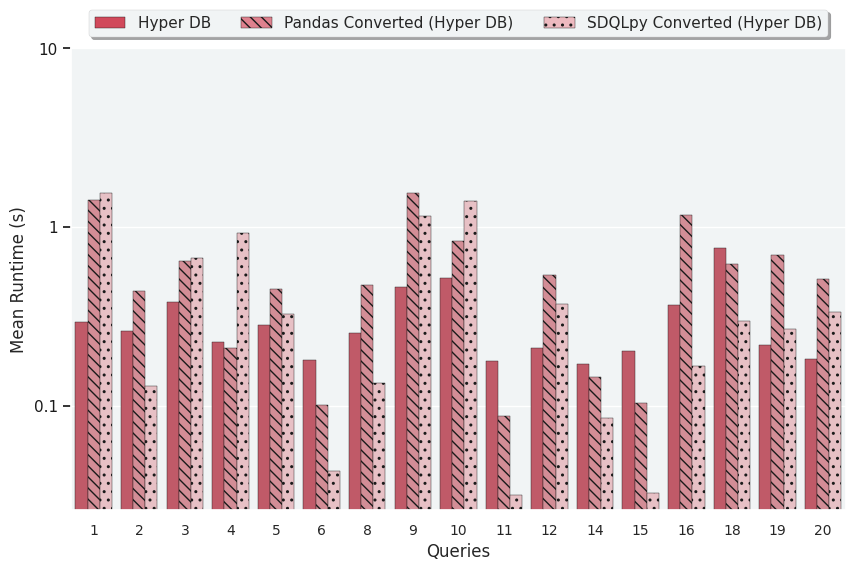

In [9]:
# Hyper VS Pandas (Hyper) - TPC-H
hyper_vs_pd_vs_sdqlpy = results[results["Query Type"].isin(["Hyper DB", "Pandas Converted (Hyper DB)", "SDQLpy Converted (Hyper DB)"])]
hyper_order = ["Hyper DB", "Pandas Converted (Hyper DB)", "SDQLpy Converted (Hyper DB)"]
hyper_color = [DBColors.HYPER.value, DBColors.PD_HYPER.value, DBColors.SDQL_HYPER.value]
hyper_hatch = [None, "\\\\\\", ".."]
hyper_filename = "../analysis_results/hyper_sdqlpy_pandas_compare_queries.jpg"

make_compare_graph(hyper_vs_pd_vs_sdqlpy, 
                   hyper_order,
                   hyper_color,
                   hyper_hatch,
                   hyper_filename)

The DataFrame has 34 rows


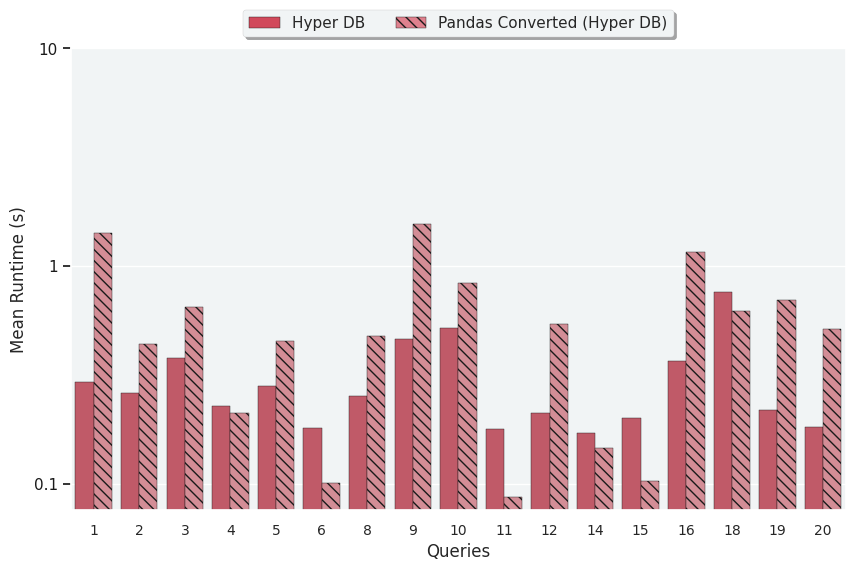

In [10]:
# Hyper VS Pandas (Hyper) - TPC-H
hyper_vs_hyper_pd = results[results["Query Type"].isin(["Hyper DB", "Pandas Converted (Hyper DB)"])]
hyper_order = ["Hyper DB", "Pandas Converted (Hyper DB)"]
hyper_color = [DBColors.HYPER.value, DBColors.PD_HYPER.value]
hyper_hatch = [None, "\\\\\\"]
hyper_filename = "../analysis_results/hyper_pandas_compare_queries.pdf"

make_compare_graph(hyper_vs_hyper_pd, 
                   hyper_order,
                   hyper_color,
                   hyper_hatch,
                   hyper_filename)

The DataFrame has 17 rows


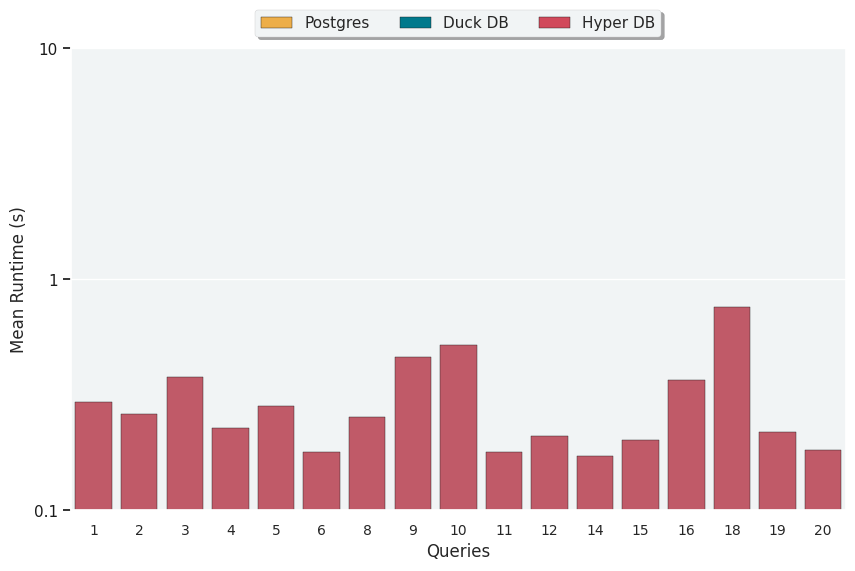

In [11]:
# Hyper VS Postgres VS Duck DB - TPC-H	

all_dbs = results[results["Query Type"].isin(["Postgres", "Duck DB", "Hyper DB"])]
all_dbs_order = ["Postgres", "Duck DB", "Hyper DB"]
all_dbs_color = [DBColors.POSTGRES.value, DBColors.DUCK.value, DBColors.HYPER.value]
all_dbs_hatch = [None, None, None]
all_dbs_filename = "../analysis_results/all_dbs_compare_queries.pdf"

make_compare_graph(all_dbs, 
                   all_dbs_order,
                   all_dbs_color,
                   all_dbs_hatch,
                   all_dbs_filename)

The DataFrame has 17 rows


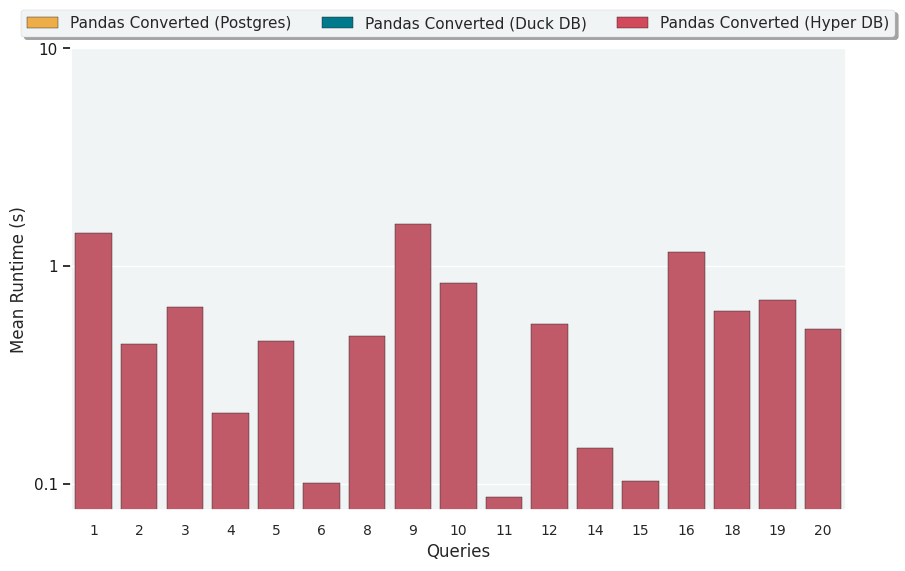

In [12]:
# Pandas (Postgres) VS Pandas (Duck DB) - TPC-H VS Pandas (Hyper)

all_pd_dbs = results[results["Query Type"].isin(["Pandas Converted (Postgres)", "Pandas Converted (Duck DB)", "Pandas Converted (Hyper DB)"])]
all_pd_dbs_order = ["Pandas Converted (Postgres)", "Pandas Converted (Duck DB)", "Pandas Converted (Hyper DB)"]
#all_pd_dbs_color = [DBColors.PD_POSTGRES.value, DBColors.PD_DUCK.value, DBColors.PD_HYPER.value]
all_pd_dbs_color = [DBColors.POSTGRES.value, DBColors.DUCK.value, DBColors.HYPER.value]
all_pd_dbs_hatch = [None, None, None]  # ["\\\\\\", "\\\\\\", "\\\\\\"]
all_pd_dbs_filename = "../analysis_results/all_pd_dbs_compare_queries.png"

make_compare_graph(all_pd_dbs, 
                   all_pd_dbs_order,
                   all_pd_dbs_color,
                   all_pd_dbs_hatch,
                   all_pd_dbs_filename)

The DataFrame has 51 rows


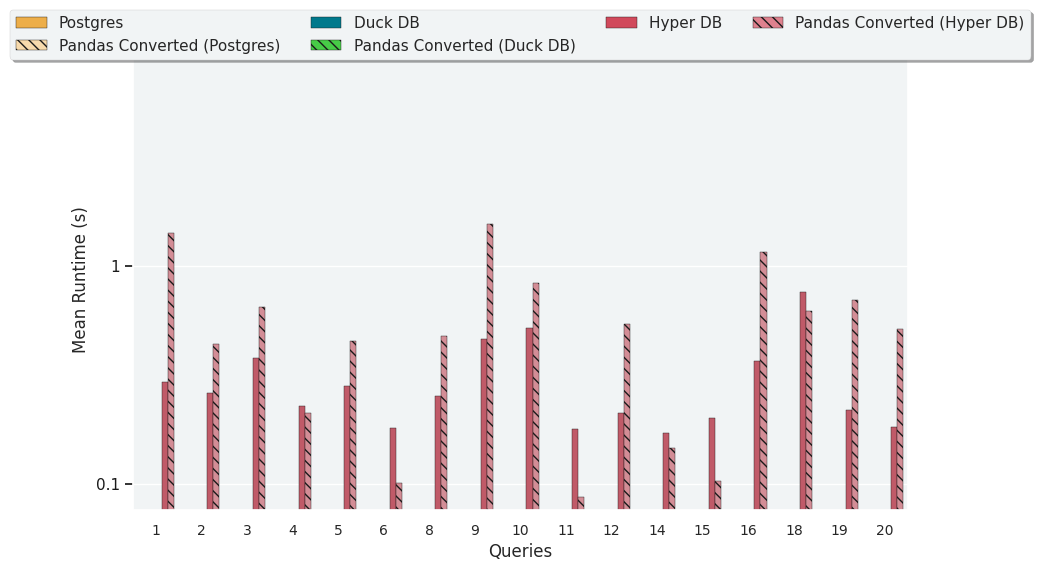

In [13]:
# All 6 Datapoints - TPC-H

all = results
all_order = ["Postgres", "Pandas Converted (Postgres)", "Duck DB", "Pandas Converted (Duck DB)", "Hyper DB", "Pandas Converted (Hyper DB)"]
all_color = [DBColors.POSTGRES.value, DBColors.PD_POSTGRES.value, DBColors.DUCK.value, DBColors.PD_DUCK.value, DBColors.HYPER.value, DBColors.PD_HYPER.value]
all_hatch = [None, "\\\\\\", None, "\\\\\\", None, "\\\\\\"]
all_filename = "../analysis_results/all_compare_queries.pdf"

make_compare_graph(all, 
                   all_order,
                   all_color,
                   all_hatch,
                   all_filename)

## Statistics

In [17]:
overall = results.groupby("Query Type").agg(
    overall_mean_runtime=("Mean", g_mean)
)
overall = overall.sort_values(by="overall_mean_runtime")
overall = overall.rename(columns={"overall_mean_runtime": "Overall Geometric Mean Runtime (s)"})

overall.head(6)

,Overall Geometric Mean Runtime (s)
Query Type,
SDQLpy Converted (Hyper DB),0.248778
Hyper DB,0.274631
Pandas Converted (Hyper DB),0.422425
